### 0. Imports and requirements

* В данном соревновании мы имеем дело с последовательностями, один из интуитивных способов работы с ними &ndash; использование рекуррентных нейронных сетей. В этом базовом решении мы демонстрируем, как можно построить хорошее решение задачи соревнования без использования сложного и трудоемкого feature engineering'а (чтобы эффективно решать ту же задачу с высоким качеством с помощью бустингов нужно несколько тысяч признаков), благодаря рекуррентным нейронным сетям. В этом ноутбуке мы построим решение с использованием фреймфорка `torch`. Для комфортной работы Вам понадобится машина с `GPU` (хватит ресурсов `google colab` или `kaggle`).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
import tqdm

# !!! измените "2" на номер доступной вам сuda
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
pd.set_option("display.max_columns", None)
sys.path.append('/kaggle/input/credit')
sys.path.append('../')

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных

In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

### 1. Data Preprocessing

In [3]:
import dataset_preprocessing_utils
print(dir(dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [4]:
TRAIN_DATA_PATH = "/kaggle/input/credit/data/train_data/"
TEST_DATA_PATH = "/kaggle/input/credit/data/test_data/"

TRAIN_TARGET_PATH = "/kaggle/input/credit/data/train_target.csv"

In [5]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


* Как и в случае с бустингами, мы не можем поместить всю выборку в память ввиду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отдельного внимания к тому, как будут предобработаны и поданы данные. Важные моменты, на которые требуется обратить внимание:
    1. Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность &ndash; все исторические кредиты клиента. Чтобы преобразовать `pd.DataFrame` с записями из кредитных историй клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_credits_to_sequences`, она производит необходимые манипуляции и возвращает фрейм с двумя колонками: `id` и `sequences`. Колонка `sequences` представляет из себя список списков длины `len(features)`, где каждый вложенный список &ndash; значения одного конкретного признака во всех кредитах клиента. 
    
    2. Клиенты могут иметь различные по длине кредитные истории. При этом обучение нейронных сетей происходит батчами и поскольку рекуррентные слои не способны обрабатывать батчи с последовательностями  неодинаковой длины, существует несколько подходов для приведения последовтельностей в батче к удобоваримому виду. Простой подход заключается в дополнении более коротких последовательностей нулями до максимальной длины последовательности в батче (т. н. паддинг). Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `Sequence Bucketing` (о ней мы рассказываем в нашем треке). Для реализации паддинга последовательностей кредитов клиентов мы подготовили функцию `dataset_preprocessing_utils.create_padded_buckets`.

In [6]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [7]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq
/kaggle/input/credit/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_8.pq
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/test_data/test_data_0.pq
/kaggle/input/credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 46.1 s, sys: 35.1 s, total: 1min 21s
Wall time: 52 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [8]:
import dataset_preprocessing_utils
print(dir(dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [9]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

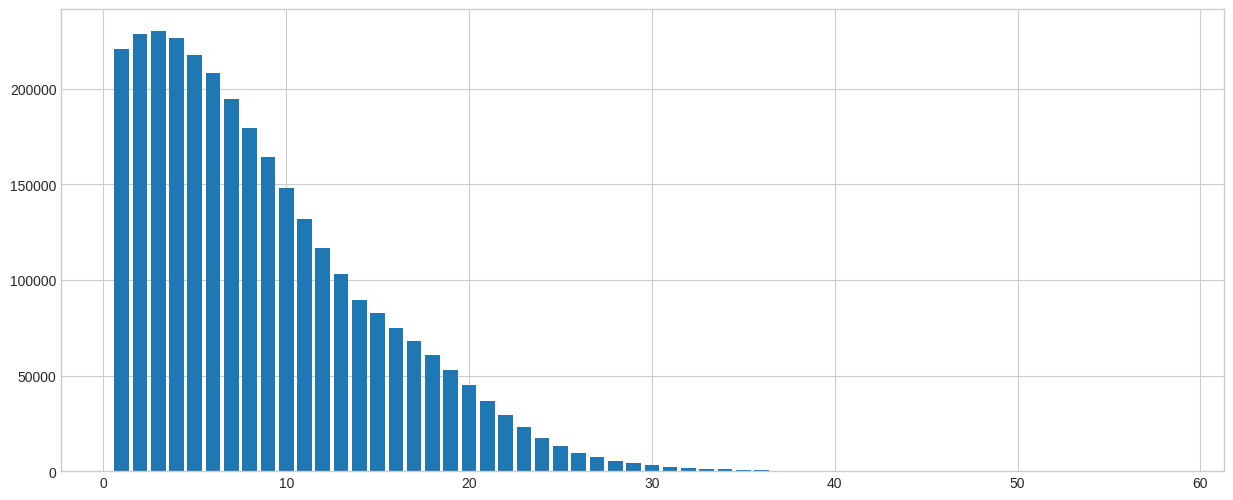

In [10]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

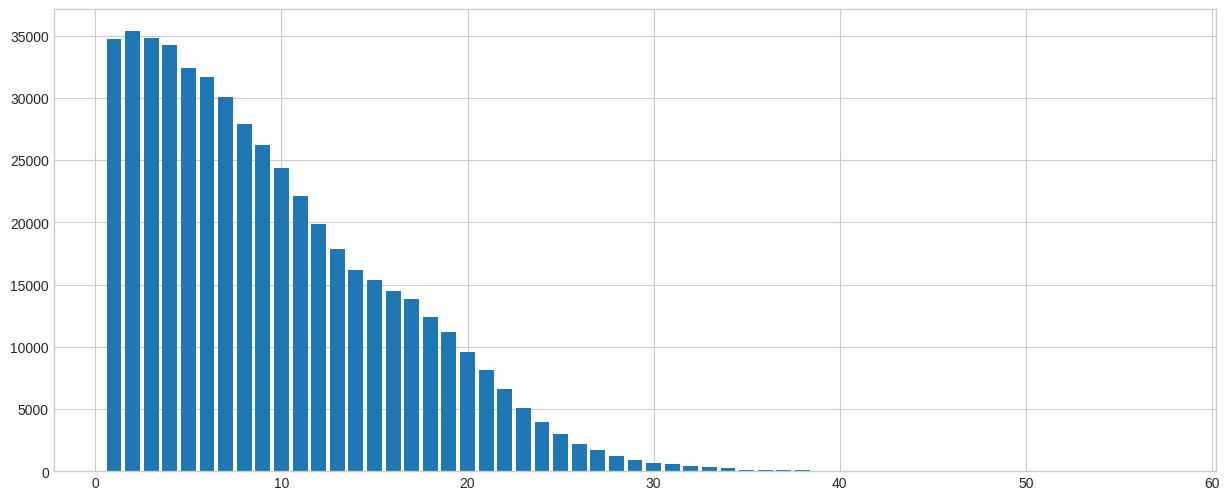

In [11]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [12]:
train_lens.max(), test_lens.max()

(58, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [13]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [14]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [15]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [16]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [17]:
TRAIN_BUCKETS_PATH = "data/train_buckets_rnn"
VAL_BUCKETS_PATH = "data/val_buckets_rnn"
TEST_BUCKETS_PATH = "data/test_buckets_rnn"

In [18]:
import shutil

for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    if os.path.exists(buckets_path):
        print(f"Удаляю папку {buckets_path}")
        shutil.rmtree(buckets_path)  # Удаляем директорию и её содержимое
    print(f"Создаю папку {buckets_path}")
    os.makedirs(buckets_path)  # Создаём директорию

Создаю папку data/train_buckets_rnn
Создаю папку data/val_buckets_rnn
Создаю папку data/test_buckets_rnn


In [19]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_3.pq
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq
/kaggle/input/credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 9min 33s, sys: 1min 15s, total: 10min 48s
Wall time: 10min 20s


['data/train_buckets_rnn/processed_chunk_000.pkl',
 'data/train_buckets_rnn/processed_chunk_001.pkl',
 'data/train_buckets_rnn/processed_chunk_002.pkl',
 'data/train_buckets_rnn/processed_chunk_003.pkl']

In [20]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_3.pq
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq
/kaggle/input/credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 8min 58s, sys: 47.1 s, total: 9min 45s
Wall time: 9min 12s


['data/val_buckets_rnn/processed_chunk_000.pkl',
 'data/val_buckets_rnn/processed_chunk_001.pkl',
 'data/val_buckets_rnn/processed_chunk_002.pkl',
 'data/val_buckets_rnn/processed_chunk_003.pkl']

In [21]:
%%time
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Preparing credit data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/test_data/test_data_0.pq
/kaggle/input/credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 12 s, total: 1min 48s
Wall time: 1min 42s


['data/test_buckets_rnn/processed_chunk_000.pkl']

### 2. Modeling

In [22]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print('Using device:', device)

Using device: cuda


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [23]:
from data_generators import batches_generator
from pytorch_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [24]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [25]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [26]:
class CreditsRNN(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32):
        super(CreditsRNN, self).__init__()
        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature]) 
                                                          for feature in features])
                        
        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                             hidden_size=rnn_units, batch_first=True, bidirectional=False)
        self._hidden_size = rnn_units
        self._top_classifier = nn.Linear(in_features=rnn_units, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
    
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, last_hidden = self._gru(concated_embeddings)
        last_hidden = torch.reshape(last_hidden.permute(1, 2, 0), shape=(batch_size, self._hidden_size))
                                
        classification_hidden = self._top_classifier(last_hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output
    
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

### 3. Training

In [27]:
!rm -rf ./checkpoints/
!mkdir ./checkpoints/

In [28]:
!rm -r ./checkpoints/pytorch_baseline
!mkdir ./checkpoints/pytorch_baseline

rm: cannot remove './checkpoints/pytorch_baseline': No such file or directory


* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [29]:
path_to_checkpoints = "./checkpoints/pytorch_baseline/"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"), 
                   metric_name="ROC-AUC", save_format="torch")

In [30]:
num_epochs = 10
train_batch_size = 128
val_batch_size = 128

In [31]:
model = CreditsRNN(features, embedding_projections).to(device)

In [32]:
model

CreditsRNN(
  (_credits_cat_embeddings): ModuleList(
    (0): Embedding(21, 9, padding_idx=0)
    (1-2): 2 x Embedding(19, 8, padding_idx=0)
    (3-4): 2 x Embedding(18, 8, padding_idx=0)
    (5): Embedding(17, 8, padding_idx=0)
    (6): Embedding(21, 9, padding_idx=0)
    (7): Embedding(9, 5, padding_idx=0)
    (8): Embedding(7, 4, padding_idx=0)
    (9): Embedding(3, 2, padding_idx=0)
    (10): Embedding(5, 3, padding_idx=0)
    (11): Embedding(15, 7, padding_idx=0)
    (12): Embedding(19, 8, padding_idx=0)
    (13): Embedding(21, 9, padding_idx=0)
    (14): Embedding(11, 6, padding_idx=0)
    (15): Embedding(7, 4, padding_idx=0)
    (16): Embedding(21, 9, padding_idx=0)
    (17-21): 5 x Embedding(3, 2, padding_idx=0)
    (22-24): 3 x Embedding(21, 9, padding_idx=0)
    (25-27): 3 x Embedding(3, 2, padding_idx=0)
    (28-38): 11 x Embedding(5, 3, padding_idx=0)
    (39): Embedding(6, 4, padding_idx=0)
    (40-47): 8 x Embedding(5, 3, padding_idx=0)
    (48): Embedding(6, 4, padding_i

In [33]:
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [34]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                shuffle=True, print_loss_every_n_batches=500, device=device)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)
    
    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))
    
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.766948).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7709371252518774, val ROC AUC: 0.7669481787655641
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.766948 --> 0.770565).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7774087516161643, val ROC AUC: 0.770565235081235
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.770565 --> 0.775713).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7848227503372085, val ROC AUC: 0.7757125175096327
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.773987. Current best: 0.775713
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7854884239714175, val ROC AUC: 0.7739865196749898
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.774464. Current best: 0.775713
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7897834119298097, val ROC AUC: 0.7744639497823901
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.772925. Current best: 0.775713
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
CPU times: user 32min 22s, sys: 1min 57s, total: 34min 19s
Wall time: 36min 32s


### 4. Submission

* Подготовим посылку в проверяющую систему

In [35]:
model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt")))

<ipython-input-35-101b553bcff6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt")))


<All keys matched successfully>

In [40]:
test_preds = inference(model, dataset_test, batch_size=128, device=device)

Test predictions: 0it [00:00, ?it/s]

In [41]:
test_preds.head()

,id,score
0,3000014,-3.203671
1,3000020,-1.652696
2,3000027,-2.893171
3,3000043,-2.156915
4,3000049,-3.745310


In [42]:
test_preds.shape

(500000, 2)

# лучший roc-auc на валидации 0.775